In [ ]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import matplotlib.pyplot as plt
import tensorflow as tf
from keras_tuner import Hyperband


Loading and Preprocessing No2 data


In [ ]:
# Load the dataset
no2_data = pd.read_csv("/content/NO2.csv")

# Preprocess the data
def preprocess_data(data, date_column="Date", value_column="Daily Max 1-hour NO2 Concentration"):
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.loc[:, [date_column, value_column]].copy()
    data.rename(columns={value_column: "NO2"}, inplace=True)
    return data

# Preprocess NO2 data
no2_data = preprocess_data(no2_data)

# Set date as the index
no2_data.set_index("Date", inplace=True)

# Drop missing values
no2_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
no2_scaled = scaler.fit_transform(no2_data)

# Create sequences for supervised learning
def create_sequences(data, time_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 7
X, y = create_sequences(no2_scaled, time_steps)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Defined LSTM with attention mechanism

In [ ]:
def lstm_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, return_sequences=True)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)

    # Attention Mechanism
    attention_scores = Dense(1, activation="tanh")(lstm_out)
    attention_weights = tf.nn.softmax(attention_scores, axis=1)
    context_vector = attention_weights * lstm_out
    context_vector = tf.reduce_sum(context_vector, axis=1)

    dense_out = Dense(1)(context_vector)

    model = Model(inputs=inputs, outputs=dense_out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    return model


Created a custom attention layer

In [ ]:
from tensorflow.keras.layers import Layer, Softmax, Dense

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.score_dense = Dense(1, activation="tanh")  # Initialize the Dense layer here
        self.softmax = Softmax(axis=1)  # Initialize Softmax here

    def call(self, inputs):
        attention_scores = self.score_dense(inputs)  # Use the initialized Dense layer
        attention_weights = self.softmax(attention_scores)  # Apply Softmax
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Updated build_model function
def build_model(hp):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    lstm_out = LSTM(
        units=hp.Int("units", min_value=32, max_value=128, step=32), return_sequences=True
    )(inputs)
    lstm_out = Dropout(hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1))(lstm_out)

    # Add the custom Attention Layer
    context_vector = AttentionLayer()(lstm_out)

    dense_out = Dense(1)(context_vector)

    model = Model(inputs=inputs, outputs=dense_out)
    model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
    return model

Hyperparameter tuning

In [ ]:
tuner = Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=10,
    factor=3,
    directory="tuning_results_no2",
    project_name="no2_lstm",
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


Trial 23 Complete [00h 00m 06s]
val_loss: 0.030402563512325287

Best val_loss So Far: 0.02979492023587227
Total elapsed time: 00h 05m 09s


Training the model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0291 - mae: 0.1338 - val_loss: 0.0315 - val_mae: 0.1497
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0330 - mae: 0.1443 - val_loss: 0.0325 - val_mae: 0.1521
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0329 - mae: 0.1422 - val_loss: 0.0328 - val_mae: 0.1527
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0326 - mae: 0.1417 - val_loss: 0.0323 - val_mae: 0.1516
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0302 - mae: 0.1371 - val_loss: 0.0314 - val_mae: 0.1496
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0323 - mae: 0.1401 - val_loss: 0.0312 - val_mae: 0.1488
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0339 - mae: 0.1425 - val_loss: 0.0302 - val_mae: 0.1455
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0343 - mae: 0.1398 - val_loss: 0.0307 - val_mae: 0.1473
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0338 - mae: 0.1386 - 

Evaluation and plot prediction

Test Loss: 0.031356681138277054
Test MAE: 0.1498299241065979
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


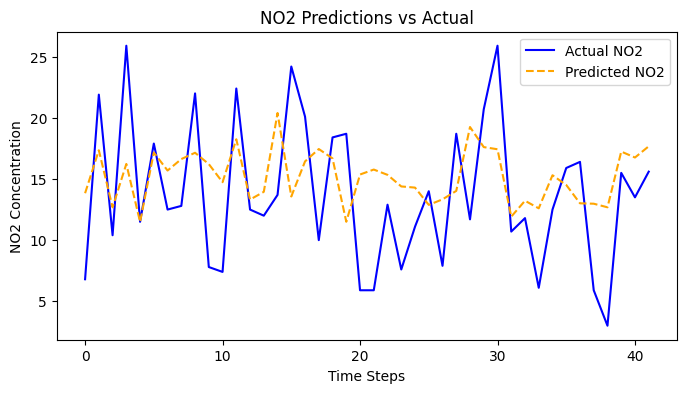

In [ ]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot Actual vs Predicted for each pollutant
# Visualize Actual vs Predicted NO2
plt.figure(figsize=(8, 4))
plt.plot(y_test_rescaled, label="Actual NO2", color='blue')
plt.plot(y_pred_rescaled, label="Predicted NO2", linestyle='--', color='orange')
plt.title("NO2 Predictions vs Actual")
plt.xlabel("Time Steps")
plt.ylabel("NO2 Concentration")
plt.legend()
plt.show()

